# Modelo de predicción de cancelación de clientes para la empresa de telecomunicaciones Interconnect

**Problema:**
Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.



## Análisis Exploratorio

In [2]:
# Library are imported

import numpy as np
import pandas as pd
import math

import seaborn as sns
 
import sklearn.preprocessing

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

In [6]:
print(np.__version__) 
print(pd.__version__)
print(sns.__version__)

1.21.2
1.2.4
0.11.1


In [873]:
# Cargamos el primer dataframe y obtenemos sus cacarcterísticas
df_contract = pd.read_csv('final_provider/contract.csv')
display(df_contract)
df_contract.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [874]:
# Se imprime el número de duplicados y sus propiedades
print(df_contract.duplicated().sum())
df_contract.describe()

0


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


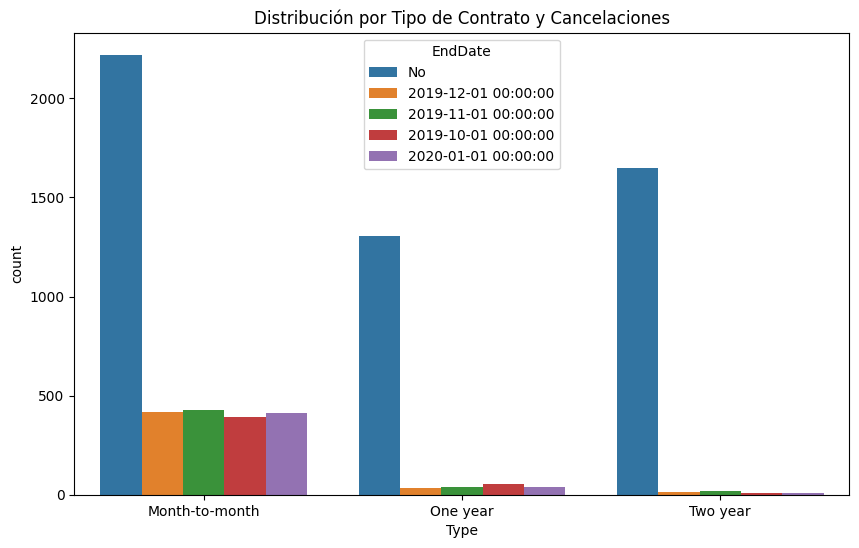

In [875]:
# Análizamos la distribución por tipo de contrato y cancelaciones
plt.figure(figsize=(10, 6))
sns.countplot(data=df_contract, x='Type', hue='EndDate')
plt.title('Distribución por Tipo de Contrato y Cancelaciones')
plt.show()

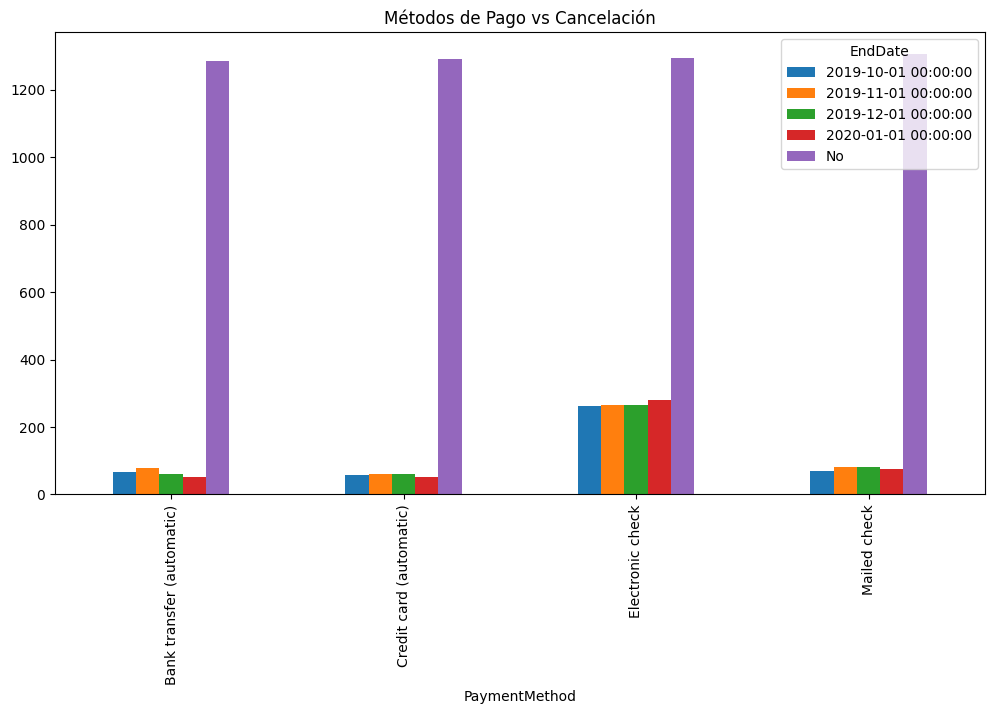

In [876]:
# Se analiza la distribución por método de pago contra cancelación
pd.crosstab(df_contract['PaymentMethod'], df_contract['EndDate']).plot(kind='bar', figsize=(12, 6))
plt.title('Métodos de Pago vs Cancelación')
plt.show()

In [877]:
df_contract.to_csv('df_contract.csv', index=False)  

In [878]:
# Cargamos el segundo dataframe y obtenemos sus cacarcterísticas
df_internet = pd.read_csv('final_provider/internet.csv')
display(df_internet)
df_internet.info()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [879]:
# Se imprime el número de duplicados y sus propiedades
print(df_internet.duplicated().sum())
df_internet.describe()

0


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,3318-NMQXL,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [880]:
# Cargamos el segundo dataframe y obtenemos sus cacarcterísticas
df_personal = pd.read_csv('final_provider/personal.csv')
display(df_personal)
df_personal.info()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [881]:
# Se imprime el número de duplicados y sus propiedades
print(df_personal.duplicated().sum())
df_personal.describe()

0


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [882]:
# Cargamos el segundo dataframe y obtenemos sus cacarcterísticas
df_phone = pd.read_csv('final_provider/phone.csv')
display(df_phone)
df_phone.info()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [883]:
# Se imprime el número de duplicados y sus propiedades
print(df_phone.duplicated().sum())

df_phone.describe()

0


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,7197-VOJMM,No
freq,1,3390


**Observaciones**

* Podemos observar de primera instancia que las cancelaciones se dan más en los pagos mes a mes y con el métodos de pago de cheque electrónico.
* Se deben normalizar los nombres de las columnas a minúsculas para un análisis más eficiente.
* Cambiar tipos de varible a las columnas que sean necesarias y cambiar o eliminar valores nulos, duplicados o valores que contengan errores de entrada.
* Unir tablas que sean necesarias.

## Preparación de los datos

In [884]:
# Unir las tablas en una sola base de datos
df = df_contract.merge(df_personal, on='customerID', how='left')
df = df.merge(df_internet, on='customerID', how='left')
df = df.merge(df_phone, on='customerID', how='left')
display(df)
df.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,NaN
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [885]:
# Eliminar columnas innecesarias
df.drop(columns=['customerID'], inplace=True)

In [886]:
# Normalizamos los nombres de las columnas en minúsculas
df.columns = df.columns.str.lower()

In [887]:
# Transformar variable objetivo
df['enddate'] = df['enddate'].where(df['enddate']=='No', 'Yes')

df['enddate'] = df['enddate'].map({'Yes': 1, 'No': 0})

In [888]:
# Cambiamos a variables numéricas las columnas necesarias
df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')
df['totalcharges'] = df['totalcharges'].fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   begindate         7043 non-null   object 
 1   enddate           7043 non-null   int64  
 2   type              7043 non-null   object 
 3   paperlessbilling  7043 non-null   object 
 4   paymentmethod     7043 non-null   object 
 5   monthlycharges    7043 non-null   float64
 6   totalcharges      7043 non-null   float64
 7   gender            7043 non-null   object 
 8   seniorcitizen     7043 non-null   int64  
 9   partner           7043 non-null   object 
 10  dependents        7043 non-null   object 
 11  internetservice   5517 non-null   object 
 12  onlinesecurity    5517 non-null   object 
 13  onlinebackup      5517 non-null   object 
 14  deviceprotection  5517 non-null   object 
 15  techsupport       5517 non-null   object 
 16  streamingtv       5517 non-null   object 


In [889]:
# Cambiamos a variables objeto las columnas necesarias
df['seniorcitizen'] = df['seniorcitizen'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   begindate         7043 non-null   object 
 1   enddate           7043 non-null   int64  
 2   type              7043 non-null   object 
 3   paperlessbilling  7043 non-null   object 
 4   paymentmethod     7043 non-null   object 
 5   monthlycharges    7043 non-null   float64
 6   totalcharges      7043 non-null   float64
 7   gender            7043 non-null   object 
 8   seniorcitizen     7043 non-null   object 
 9   partner           7043 non-null   object 
 10  dependents        7043 non-null   object 
 11  internetservice   5517 non-null   object 
 12  onlinesecurity    5517 non-null   object 
 13  onlinebackup      5517 non-null   object 
 14  deviceprotection  5517 non-null   object 
 15  techsupport       5517 non-null   object 
 16  streamingtv       5517 non-null   object 


In [890]:
# Reemplazamos valores nulos
df = df.fillna('No')

display(df)
df.info()

,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
0,2020-01-01,0,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No
1,2017-04-01,0,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,2019-10-01,1,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,2016-05-01,0,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No
4,2019-09-01,1,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2018-02-01,0,One year,Yes,Mailed check,84.80,1990.50,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2014-02-01,0,One year,Yes,Credit card (automatic),103.20,7362.90,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,2019-03-01,0,Month-to-month,Yes,Electronic check,29.60,346.45,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,No
7041,2019-07-01,1,Month-to-month,Yes,Mailed check,74.40,306.60,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   begindate         7043 non-null   object 
 1   enddate           7043 non-null   int64  
 2   type              7043 non-null   object 
 3   paperlessbilling  7043 non-null   object 
 4   paymentmethod     7043 non-null   object 
 5   monthlycharges    7043 non-null   float64
 6   totalcharges      7043 non-null   float64
 7   gender            7043 non-null   object 
 8   seniorcitizen     7043 non-null   object 
 9   partner           7043 non-null   object 
 10  dependents        7043 non-null   object 
 11  internetservice   7043 non-null   object 
 12  onlinesecurity    7043 non-null   object 
 13  onlinebackup      7043 non-null   object 
 14  deviceprotection  7043 non-null   object 
 15  techsupport       7043 non-null   object 
 16  streamingtv       7043 non-null   object 


In [891]:
# Identificar variables categóricas y numéricas
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('enddate')

display(cat_cols)
display(num_cols)

Index(['begindate', 'type', 'paperlessbilling', 'paymentmethod', 'gender',
       'seniorcitizen', 'partner', 'dependents', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'multiplelines'],
      dtype='object')

Index(['monthlycharges', 'totalcharges'], dtype='object')

In [892]:
# Preprocesamiento: One-Hot Encoding para categóricas y escalado para numéricas
preprocessor = ColumnTransformer([('num', StandardScaler(), num_cols),('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)])

## Entrenamiento

In [893]:
# Dividir en conjuntos de entrenamiento y prueba
X = df.drop(columns=['enddate'])
y = df['enddate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [894]:
# Modelos a evaluar
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=12345),
    'Random Forest': RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=100, random_state=12345),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=500, learning_rate=0.2, random_state=12345)
}

In [895]:
pipeline1 = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', models['Logistic Regression'])])
pipeline1.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['monthlycharges', 'totalcharges'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['begindate', 'type', 'paperlessbilling', 'paymentmethod', 'gender',
       'seniorcitizen', 'partner', 'dependents', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'multiplelines'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=12345))])

In [896]:
pipeline2 = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', models['Random Forest'])])
pipeline2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['monthlycharges', 'totalcharges'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['begindate', 'type', 'paperlessbilling', 'paymentmethod', 'gender',
       'seniorcitizen', 'partner', 'dependents', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'multiplelines'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=100,
                                        random_state=12345))])

In [897]:
pipeline3 = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', models['Gradient Boosting'])])
pipeline3.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['monthlycharges', 'totalcharges'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['begindate', 'type', 'paperlessbilling', 'paymentmethod', 'gender',
       'seniorcitizen', 'partner', 'dependents', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'multiplelines'],
      dtype='object'))])),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.2, n_estimators=500,
                                            random_state=12345))])

## Prueba

In [898]:
y_pred_prob1 = pipeline1.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob1)
print(f'Logistic Regression AUC-ROC: {auc:.4f}')

Logistic Regression AUC-ROC: 0.8512


In [899]:
y_pred_prob2 = pipeline2.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob2)
print(f'Random Forest AUC-ROC: {auc:.4f}')

Random Forest AUC-ROC: 0.8624


In [900]:
y_pred_prob3 = pipeline3.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob3)
print(f'Gradient Boosting AUC-ROC: {auc:.4f}')

Gradient Boosting AUC-ROC: 0.9125


En conclusión, el modelo que mejor funcionó para estos datos fué "Gradient Boosting" con 91.25% en la métrica AUC-ROC superando por más de 3% el mínimo que se buscaba en este trabajo. En un trabajo a futuro se podrían implementar más modelos para observar si uno supera esta puntuación e incluir un buscador de mejores hiperparámetros.